In [1]:
import argparse
import sys
import time as t

import cv2
import numpy as np
from matplotlib import cm
from PIL import Image
from IPython.display import display
from skimage import data
from skimage . color import rgb2gray
import matplotlib.pyplot as plt

In [2]:
left_name = 'teddy/im2.png' # name (path) to the left image
right_name = 'teddy/im6.png' # name (path) to the right image
left_gt_name = 'teddy/disp2.png' # name (path) to the left ground-truth image
right_gt_name = 'teddy/disp6.png' # name (path) to the right ground-truth image
max_disparity = 64 # maximum disparity for the stereo pair
P1 = 10 # penalty for disparity difference = 1
P2 = 120 # penalty for disparity difference > 1
csize = (5, 5) # size of the kernel for the census transform.
bsize = (3, 3) # size of the kernel for blurring the images and median filtering.

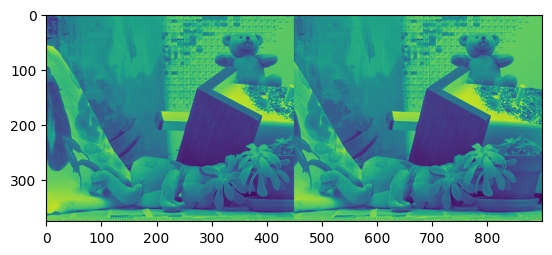

In [3]:
left = cv2.imread(left_name, cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_name, cv2.IMREAD_GRAYSCALE)

height = left.shape[0]
width = left.shape[1]
joined_gray = np.concatenate([left, right], axis=1)
plt.imshow(joined_gray)

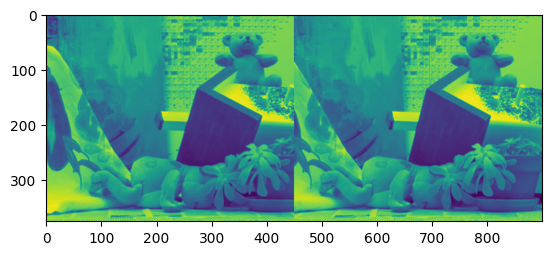

In [4]:
# Ajout d'un flou gaussien sur l'image
left = cv2.GaussianBlur(left, bsize, 0, 0)
right = cv2.GaussianBlur(right, bsize, 0, 0)

joined_smoothed = np.concatenate([left, right], axis=1)
plt.imshow(joined_smoothed)

In [5]:
def compute_census(left, right, csize, height, width):
    """
    Calculate census bit strings for each pixel in the left and right images.
    Arguments:
        - left: left grayscale image.
        - right: right grayscale image.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right images with pixel intensities replaced with census bit strings.
    """
    cheight = csize[0]
    cwidth = csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)

    left_census_values = np.zeros(shape=(height, width), dtype=np.uint64)
    right_census_values = np.zeros(shape=(height, width), dtype=np.uint64)

    print('\tComputing left and right census...', end='')
    sys.stdout.flush()
    dawn = t.time()
    # offset is used since pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            # left
            center_pixel = left[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = left[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            left_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            left_census_pixel = np.int32(left_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            left_census_values[y, x] = left_census_pixel

            # right
            center_pixel = right[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = right[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            right_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            right_census_pixel = np.int32(right_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            right_census_values[y, x] = right_census_pixel

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_census_values, right_census_values

In [6]:
left_census, right_census = compute_census(left, right, csize, height, width)

	Computing left and right census...	(done in 7.42s)


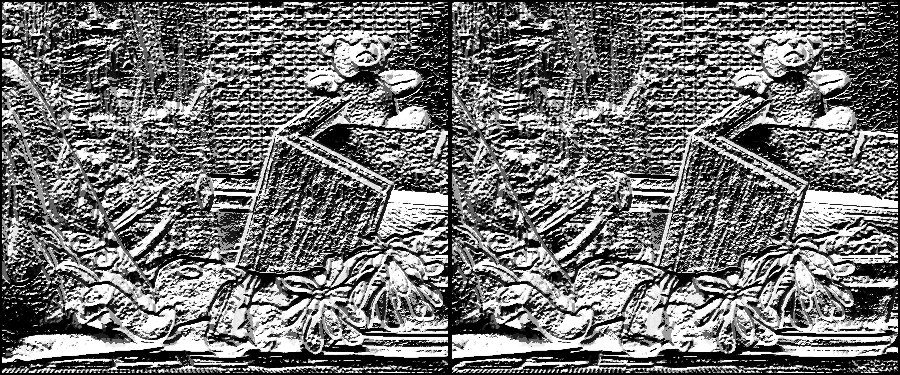

In [7]:
joined_census = np.concatenate([np.uint8(left_census), np.uint8(right_census)], axis=1)
display(Image.fromarray(joined_census))

In [8]:
def compute_costs(left_census_values, right_census_values, max_disparity, csize, height, width):
    """
    Create cost volume for all potential disparities. 
    Cost volumes for both left and right images are calculated.
    Hamming distance is used to calculate the matching cost between 
    two pixels census values.
    Arguments:
        - left_census_values: left image containing census bit strings for each pixel (in integer form).
        - right_census_values: right image containing census bit strings for each pixel (in integer form).
        - max_disparity: maximum disparity to measure.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right cost volumes with dimensions H x W x D.
    """
    cwidth = csize[1]
    x_offset = int(cwidth / 2)

    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, max_disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int32)
    rcensus = np.zeros(shape=(height, width), dtype=np.int32)

    for d in range(0, max_disparity):
        # The right image is shifted d pixels accross
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        left_xor = np.int32(np.bitwise_xor(np.int32(left_census_values), rcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        left_cost_volume[:, :, d] = left_distance

        # The left image is shifted d pixels accross
        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        # 1 is assigned when the bits differ and 0 when they are the same
        right_xor = np.int32(np.bitwise_xor(np.int32(right_census_values), lcensus))
        # All the 1's are summed up to give us the number of different pixels (the cost)
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        # All the costs for that disparity are added to the cost volume
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume

In [9]:
left_cost_volume, right_cost_volume = compute_costs(left_census, right_census, max_disparity, csize, height, width)

	Computing cost volumes...	(done in 9.06s)


In [10]:
def normalize(disp, max_disparity):
    """
    Normalizes the disparity map, then
    quantizes it so that it can be displayed. 
    Arguments:
        - disp: disparity map with dimensions H x W.
        - max_disparity: maximum disparity of the array.
    
    Return: normalized then quantized array, ready for visualization.
    """
    return 255.0 * disp / max_disparity

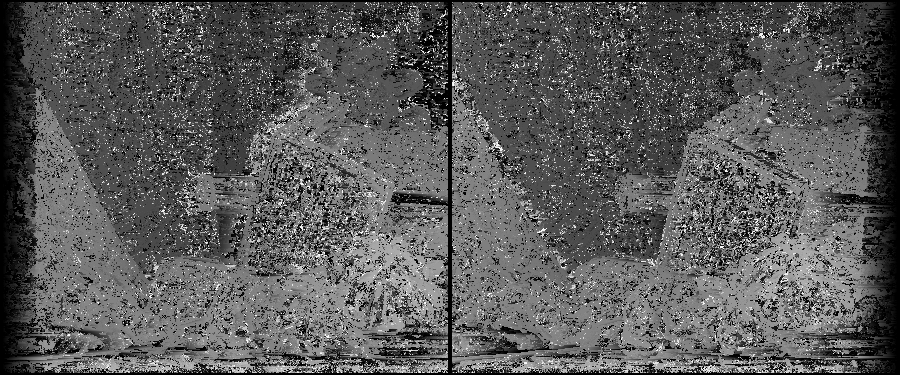

In [11]:
left_costs = np.uint8(normalize(np.argmin(left_cost_volume, axis=2), max_disparity))
right_costs = np.uint8(normalize(np.argmin(right_cost_volume, axis=2), max_disparity))

joined_costs = np.concatenate([left_costs, right_costs], axis=1)
display(Image.fromarray(joined_costs))

In [12]:
def get_penalties(max_disparity, P2, P1):
    """
    Creates a matrix of all the potential penalties for matching
    a current disparity (represented by the column index), with 
    a previous disparity (represented by the row index).
    Arguments:
        - max_disparity: Maximum disparity of the array.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
    
    Return: Matrix containing all the penalties when disparity d1 from a column
            is matched with a previous disparity d2 from the row.
    """
    p2 = np.full(shape=(max_disparity, max_disparity), fill_value=P2, dtype=np.uint32)
    p1 = np.full(shape=(max_disparity, max_disparity), fill_value=P1 - P2, dtype=np.uint32)
    p1 = np.tril(p1, k=1) # keep values lower than k'th diagonal
    p1 = np.triu(p1, k=-1) # keep values higher than k'th diagonal
    no_penalty = np.identity(max_disparity, dtype=np.uint32) * -P1 # create diagonal matrix with values -p1
    penalties = p1 + p2 + no_penalty
    return penalties


def get_path_cost(slice, offset, penalties, other_dim, disparity_dim):
    """
    Calculates the minimum costs for all potential disparities of 
    the pixels along a single path direction.
    Arguments:
        - slice: Array containing costs for all disparities, D, 
            along a direction, M, with dimension M x D
        - offset: Number of pixels on the border to ignore.
        - penalties: Matrix containing the penalties to assign to the 
            previous disparities costs. For previous disparities that differ 
            from current disparities. 
        - other_dim: Number of pixels in the current paths direction.
        - disparity_dim: Number of disparities to calculate minimum costs.

    Returns: The pixels minimum costs for all disparities, D, 
        along path direction, M, with shape M x D.
    """
    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=np.uint32)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for pixel_index in range(offset, other_dim):
        # Get all the minimum disparities costs from the previous pixel in the path
        previous_cost = minimum_cost_path[pixel_index - 1, :]
        # Get all the disparities costs (from the cost volume) for the current pixel
        current_cost = slice[pixel_index, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        # Add penalties to the previous pixels disparities that differ from current pixels disparities
        costs = costs + penalties
        # Find minimum costs for the current pixels disparities using the previous disparities costs + penalties 
        costs = np.amin(costs, axis=0)  
        # Current pixels disparities costs + minimum previous pixel disparities costs (with penalty) - 
        # (constant term) minimum previous cost from all disparities 
        pixel_direction_costs = current_cost + costs - np.amin(previous_cost)
        minimum_cost_path[pixel_index, :] = pixel_direction_costs

    return minimum_cost_path    


def aggregate_costs(cost_volume, P2, P1, height, width, disparities):
    """
    Calculates the pixels costs for all disparities along all paths (4 in this case).

    Arguments: 
        - cost_volume: Array containing the matching cost for each pixel at each disparity.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
        - height: Number of rows of the image.
        - width: Number of columns of the image.
        - disparities: Number of disparities to calculate minimum matching costs.

    Returns: Array containing the pixels matching costs for all disparities along 
        all directions, with dimension H x W x D X 4.
    """
    sys.stdout.flush()
    dawn = t.time()

    penalties = get_penalties(disparities, P2, P1)

    print("\tProcessing North and South aggregation...")
    south_aggregation = np.zeros(shape=(height, width, disparities), dtype=np.uint32)
    north_aggregation = np.copy(south_aggregation)

    for x in range(0, width):
        # Takes all the rows and disparities for a single column
        south = cost_volume[:, x, :]
        # Invert the rows to get the opposite direction
        north = np.flip(south, axis=0)
        south_aggregation[:, x, :] = get_path_cost(south, 1, penalties, height, disparities)
        north_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, penalties, height, disparities), axis=0)


    print("\tProcessing East and West aggregation...", end='')
    east_aggregation = np.copy(south_aggregation)
    west_aggregation = np.copy(south_aggregation)
    for y in range(0, height):
        # Takes all the column and disparities for a single row
        east = cost_volume[y, :, :]
        # Invert the columns to get the opposite direction
        west = np.flip(east, axis=0)
        east_aggregation[y, :, :] = get_path_cost(east, 1, penalties, width, disparities)
        west_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, penalties, width, disparities), axis=0)

    # Combine the costs from all paths into a single aggregation volume
    aggregation_volume = np.concatenate((south_aggregation[..., None], north_aggregation[..., None], east_aggregation[..., None], west_aggregation[..., None]), axis=3)

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return aggregation_volume

In [13]:
get_penalties(max_disparity, P2, P1)

array([[  0,  10, 120, ..., 120, 120, 120],
       [ 10,   0,  10, ..., 120, 120, 120],
       [120,  10,   0, ..., 120, 120, 120],
       ...,
       [120, 120, 120, ...,   0,  10, 120],
       [120, 120, 120, ...,  10,   0,  10],
       [120, 120, 120, ..., 120,  10,   0]])

In [14]:
print('\nStarting left aggregation computation...')
left_aggregation_volume = aggregate_costs(left_cost_volume, P2, P1, height, width, max_disparity)


Starting left aggregation computation...
	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 40.30s)


In [15]:
print('\nStarting right aggregation computation...')
right_aggregation_volume = aggregate_costs(right_cost_volume, P2, P1, height, width, max_disparity)


Starting right aggregation computation...
	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 34.76s)


In [16]:
def select_disparity(aggregation_volume):
    """
    Converts the aggregation volume into a disparity map using 
    the winner takes all strategy. 
    Cost volume is first calculated by taking the sum of the costs over all paths.
    Then the disparities are determined by finding the 
    disparity index with the lowest cost for the pixel.

    Arguments:
        - aggregation_volume: Array containing the matching costs for 
            all pixels at all disparities and paths, with dimension H x W x D x N

    Returns: Disparity map with dimensions H x W.
    """
    # sum up costs for all directions
    volume = np.sum(aggregation_volume, axis=3) 
    # returns the disparity index with the minimum cost associated with each h x w pixel
    disparity_map = np.argmin(volume, axis=2) 
    return disparity_map

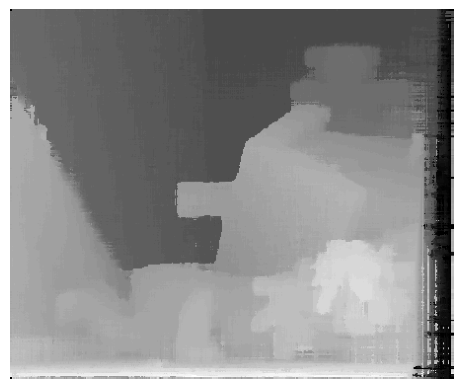

In [36]:
left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), max_disparity))
right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), max_disparity))

joined_disparity_map = np.concatenate([left_disparity_map, right_disparity_map], axis=1)
#display(Image.fromarray(joined_disparity_map))
plt.axis('off')
plt.margins(0,0)
plt.imshow(right_disparity_map, cmap='gray')
plt.savefig("sgbm.png", bbox_inches='tight',
    pad_inches = 0)


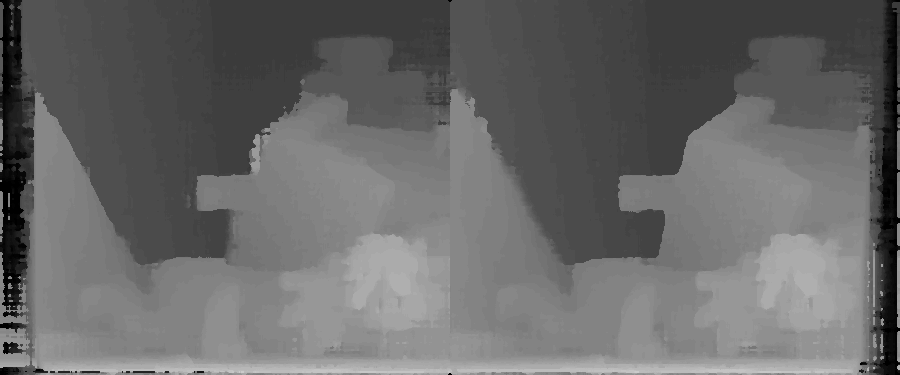

In [18]:
left_disparity_map_smoothed = cv2.medianBlur(left_disparity_map, bsize[0])
right_disparity_map_smoothed = cv2.medianBlur(right_disparity_map, bsize[0])

joined_disparity_map_smoothed = np.concatenate([left_disparity_map_smoothed, right_disparity_map_smoothed], axis=1)
display(Image.fromarray(joined_disparity_map_smoothed))

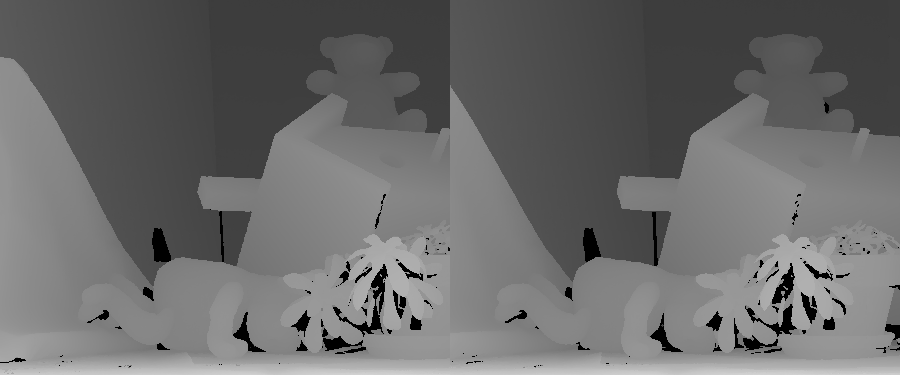

In [19]:
left_gt = cv2.imread(left_gt_name, cv2.IMREAD_GRAYSCALE)
right_gt = cv2.imread(right_gt_name, cv2.IMREAD_GRAYSCALE)

joined_gt = np.concatenate([left_gt, right_gt], axis=1)
display(Image.fromarray(joined_gt))

In [20]:
def get_recall(disparity, gt, max_disparity):
    """
    Calculates the percentage of pixels from the 
    disparity map "disparity" within 3 absolute 
    disparity of the ground truth "gt". 
    Higher percentage is better.

    Arguments:
        - disparity: 
        - gt: 
        - max_disparity: 

    Returns: Percentage of pixels within 3 disparity of 
    the groundtruth.
    """
    gt = np.float32(gt)
    gt = np.int16(gt / 255.0 * float(max_disparity))
    disparity = np.int16(np.float32(disparity) / 255.0 * float(max_disparity))
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

In [21]:
print('\nEvaluating left disparity map...')
recall = get_recall(left_disparity_map, left_gt, max_disparity)
print('\tRecall = {:.2f}%'.format(recall * 100.0))
print('\nEvaluating right disparity map...')
recall = get_recall(right_disparity_map, right_gt, max_disparity)
print('\tRecall = {:.2f}%'.format(recall * 100.0))


Evaluating left disparity map...
	Recall = 86.57%

Evaluating right disparity map...
	Recall = 88.18%


In [22]:
def create_depth_map(disp, cmap='jet'):
    """
    Converts single channel disparity map
    to an RGB depth map.
    Arguments:
      - disp: Quantized (uint8) disparity map with dimensions H x W 
      - cmap: a valid cmap named for use with matplotlib's 'get_cmap'
    
    Returns an RGB depth map with dimension H x W x 3.
    """
    color_map = cm.get_cmap(cmap)
    colors = color_map(np.arange(256))[:, :3].astype(np.float32)
    depth_map = np.take(colors, disp, axis=0)
    depth_map = np.uint8(depth_map * 255)
    return depth_map

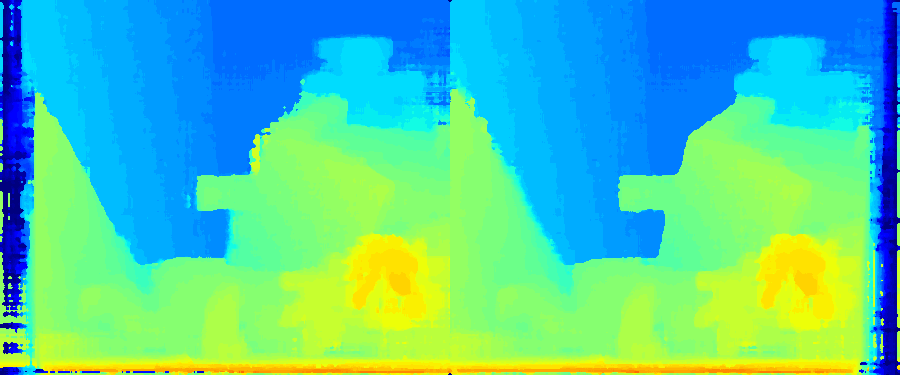

In [23]:
left_depth_map = create_depth_map(left_disparity_map_smoothed)
right_depth_map = create_depth_map(right_disparity_map_smoothed)

joined_depth_map = np.concatenate([left_depth_map, right_depth_map], axis=1)
display(Image.fromarray(joined_depth_map))

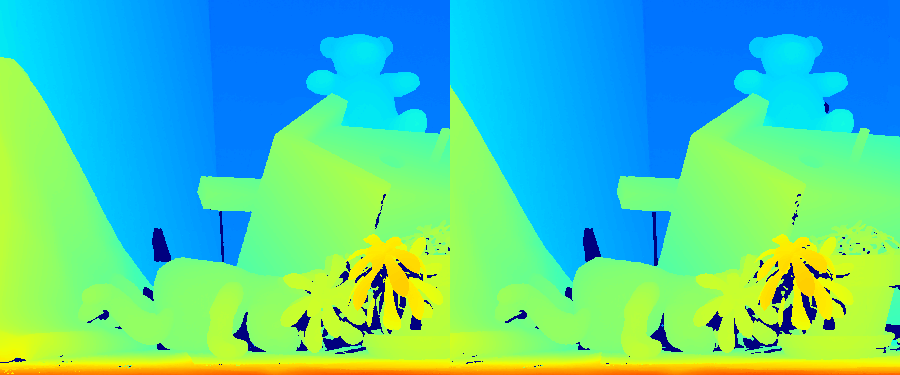

In [24]:
left_depth_map_gt = create_depth_map(left_gt)
right_depth_map_gt = create_depth_map(right_gt)

joined_depth_map_gt = np.concatenate([left_depth_map_gt, right_depth_map_gt], axis=1)
display(Image.fromarray(joined_depth_map_gt))

In [2]:
def compute_census(left, right, csize, height, width):
    """
    Calculate census bit strings for each pixel in the left and right images.
    Arguments:
        - left: left grayscale image.
        - right: right grayscale image.
        - csize: kernel size for the census transform.
        - height: number of rows of the image.
        - width: number of columns of the image.

    Return: Left and right images with pixel intensities replaced with census bit strings.
    """
    cheight = csize[0]
    cwidth = csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)

    left_census_values = np.zeros(shape=(height, width), dtype=np.uint64)
    right_census_values = np.zeros(shape=(height, width), dtype=np.uint64)

    print('\tComputing left and right census...', end='')
    sys.stdout.flush()
    dawn = t.time()
    # offset is used since pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            # left
            center_pixel = left[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = left[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            left_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            left_census_pixel = np.int32(left_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            left_census_values[y, x] = left_census_pixel

            # right
            center_pixel = right[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int32)
            image = right[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            # If value is less than center value assign 1 otherwise assign 0 
            right_census_pixel_array = np.where(comparison < 0, 1, 0).flatten()
            # Convert census array to an integer by using bit shift operator
            right_census_pixel = np.int32(right_census_pixel_array.dot(1 << np.arange(cheight * cwidth)[::-1])) 
            right_census_values[y, x] = right_census_pixel

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_census_values, right_census_values


In [2]:
# Importer les bibliothèques nécessaires
import cv2
import numpy as np
from numba import njit
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time as t
from skimage import io
import imageio
import sys

In [9]:
@njit
def ZSSD(patch1, patch2):
    mean1 = np.mean(patch1)
    mean2 = np.mean(patch2)
    patch1_normalized = patch1 - mean1
    patch2_normalized = patch2 - mean2
    zssd_score = np.square(patch1_normalized - patch2_normalized).sum()
    return zssd_score

@njit
def SGBM_cost(Iref, Isearch, block_size, maxdisp, similarity):
    # Calcul des coûts initiaux
    margin =  block_size // 2
    costs = np.zeros((maxdisp, Iref.shape[0], Iref.shape[1]))
    for d in range(maxdisp):
        for i in range(margin, Iref.shape[0] - margin):
            for j in range(margin, Iref.shape[1] - margin):
                ref_block = Iref[i - margin:i + margin + 1, j - margin:j + margin + 1]
                search_block = Isearch[i - margin:i + margin + 1, j - margin - d:j + margin + 1 - d]
                if ref_block.shape == search_block.shape:
                    costs[d, i, j] = similarity(ref_block, search_block)

    return costs

@njit
def SGBM_reg(Iref, Isearch, block_size, maxdisp, similarity, P1, P2):
    # Calcul des coûts cumulés avec régularisation
    
    margin =  block_size // 2
    cumulative_costs = np.zeros((maxdisp, Iref.shape[0], Iref.shape[1]))
    
    # Calcul des coûts initiaux
    costs = SGBM_cost(Iref, Isearch, block_size, maxdisp, similarity)
    
    for d in range(maxdisp):
        for i in range(margin, Iref.shape[0] - margin):
            for j in range(margin, Iref.shape[1] - margin):
                min_cost = np.inf
                for d_prev in range(max(0, d - 1), min(maxdisp, d + 2)):
                    cost = costs[d_prev, i, j] + P1 * (abs(d - d_prev)) - P2 * max(abs(d - d_prev), 1)
                    #cost = costs[d, i, j] + min()
                    if cost < min_cost:
                        min_cost = cost
                cumulative_costs[d, i, j] = min_cost

    return cumulative_costs

@njit
def semi_global_matching(Iref, Isearch, block_size, maxdisp, similarity, P1, P2):
    margin =  block_size // 2
    disp = np.zeros_like(Iref)
    
    
    # Calcul des coûts cumulés avec régularisation
    regs = SGBM_reg(Iref, Isearch, block_size, maxdisp, similarity, P1, P2)
    #print(regs.shape)
    #print(disp.shape, Iref.shape[0] - margin, Iref.shape[1] - margin)
    # Calcul de la disparité
    for i in range(margin, Iref.shape[0] - margin):
        for j in range(margin, Iref.shape[1] - margin):
            min_cost = np.inf
            min_disp = 0
            for d in range(maxdisp):
                cost = regs[d, i, j]
                if cost < min_cost:
                    min_cost = cost
                    min_disp = d
            disp[i, j] = min_disp
    
    return disp

@njit
def mode_filter(img, N=5):
    h, w = img.shape
    filtered_img = np.zeros_like(img)

    margin = N//2
    # Parcourir chaque pixel de la carte de disparités
    for i in range(h):
        for j in range(w):
            # Extraire la fenêtre 5x5 centrée sur le pixel actuel
            block = img[max(0, i - margin):min(h, i + margin+1), max(0, j - margin):min(w, j + margin+1)]

            occ = {val:0 for val in set(block.flatten())}
            for val in block.flatten():
                occ[val]+=1
                
            max_k=0
            max_val=0
            for key, value in occ.items():
                if value > max_val:
                    max_k=key
                    max_val=value
            filtered_img[i,j]=max_k

    return filtered_img



Im (375, 450) (375, 450)
SGBM 	(done in 5.85s)
(375, 450)


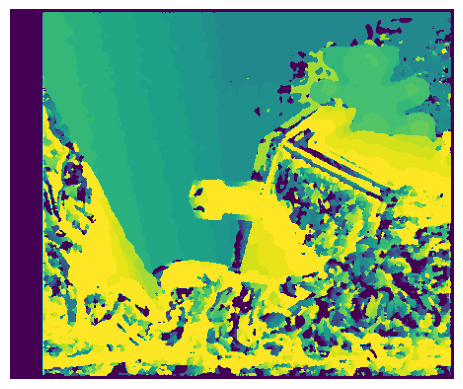

In [10]:
def normalize(disp, max_disparity):
    return 255.0 * disp / max_disparity

# Définir les paramètres
block_size = 7  # Taille des blocs
maxdisp = 32  # Disparité maximale

P1 = 1 # penalty for disparity difference = 1
P2 = 20 # penalty for disparity difference > 1


sgm = cv2.StereoSGBM_create(numDisparities = maxdisp, P1=P1, P2=P2, blockSize=block_size)

# Créer vos images de référence et de recherche (à remplacer par vos propres images)
Iref = rgb2gray(cv2.imread("teddy/im2.png"))
Isearch = rgb2gray(cv2.imread("teddy/im6.png"))

Iref = cv2.imread("teddy/im2.png", cv2.IMREAD_GRAYSCALE)
Isearch = cv2.imread("teddy/im6.png", cv2.IMREAD_GRAYSCALE)
print("Im", Iref.shape, Isearch.shape)

#disp_sgm = sgm.compute(Iref, Isearch).astype(np.float32) / 16.0
#plt.imshow(disp_sgm, cmap="gray")
#plt.show()

#Iref, Isearch = compute_census(Iref, Isearch, (5,5), Iref.shape[0], Iref.shape[1])

# Appeler la fonction semi_global_matching
dawn = t.time()
disp = semi_global_matching(Iref, Isearch, block_size, maxdisp, ZSSD, P1, P2)
dusk = t.time()
print('SGBM \t(done in {:.2f}s)'.format(dusk - dawn))
print(disp.shape)

# Postprocessing
disp = mode_filter(disp, 3)
#disp = np.interp(disp, (0, maxdisp), (0, 255)).astype(np.uint8)

disp = normalize(disp, maxdisp)
disp = np.where(disp <= 35, 0, disp)
disp[:,0:maxdisp+1] = 0
plt.axis('off')
plt.imshow(disp)
imageio.imwrite("sgbm_cones_post.png", disp.astype(np.uint8))

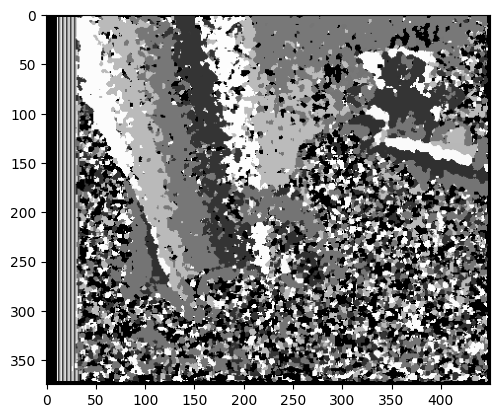

In [12]:
def normalize(disp, max_disparity):
    return 255.0 * disp / max_disparity

disp_norm = np.uint8(normalize(disp, maxdisp))

plt.imshow(disp_norm, cmap="gray")

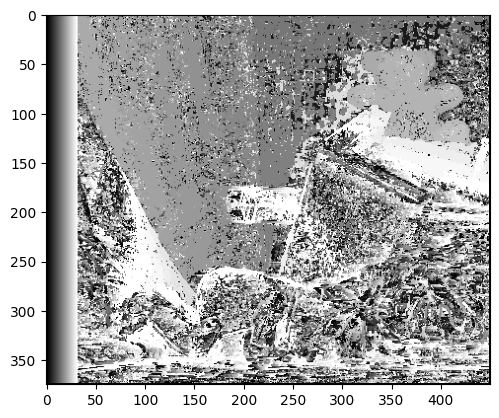

In [33]:
test = rgb2gray(cv2.imread("sgbm_teddy.png"))
plt.imshow(test, cmap="gray")

In [155]:
i = io.imread("teddy/occl.png", as_gray=True)
i.shape

(375, 450)